In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch, torchvision
import numpy as np
rng = np.random.default_rng()
import time
from tqdm.notebook import tqdm   ### suitable for notebooks

In [3]:
fname = 'MNIST_torch'

### Download and initialize datasets
TrainDS_orig = torchvision.datasets.MNIST(fname, train=True, download=True)
TestDS_orig = torchvision.datasets.MNIST(fname, train=False)

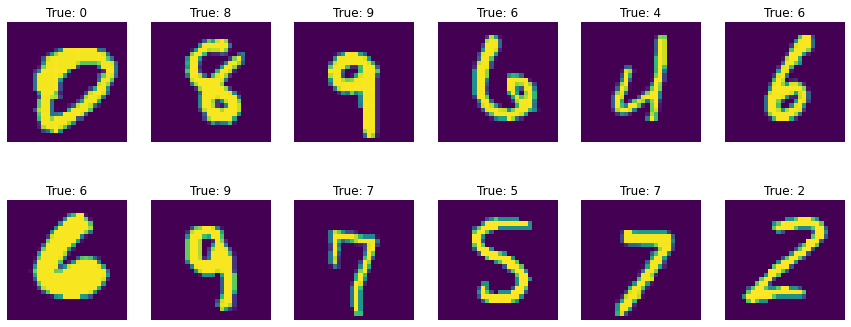

In [4]:
### Plot examples
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS_orig))
        image, orig_label = TestDS_orig[test_index]
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i' % orig_label)

In [5]:
### Define the label transform from an integer to a set of probabilities
def target_transform(inlabel):
    newlabel = torch.zeros(10)
    newlabel[inlabel] = 1.
    return newlabel

### Reinitialize datasets with the transforms
TrainDS = torchvision.datasets.MNIST(fname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))
TestDS = torchvision.datasets.MNIST(fname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))

### Initialize DataLoaders as PyTorch convenience
TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=200)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=1000)

### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

### Define the dense neuron layer
# Network = torch.nn.Sequential(
#     torch.nn.Flatten(),            # 28x28 -> 784
#     torch.nn.Linear(784, 10),      # 784 -> 10
#     torch.nn.Softmax(dim=1)
# )
Network = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.Softmax(dim=1)
)
Network.to(device=device)

### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
crit = torch.nn.BCELoss()
# crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=0.4)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): Softmax(dim=1)
)
203530 trainable parameters


In [6]:
### Baseline: just say it's anything at probability 1/N, what's the loss?
N = 10
labels = torch.zeros(1, 10, dtype=torch.float32)
labels[0, 3] = 1.
output = torch.full_like(labels, 1./N)
print(crit(output, labels))

tensor(0.3251)


In [7]:
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, 16)

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for inputs, labels in tqdm(TrainDL, leave=False):
        opt.zero_grad() # zero gradient values
        inputs = inputs.to(device=device) # move input and label tensors to the device with the model
        labels = labels.to(device=device)
        outputs = Network(inputs) # compute model outputs
        loss = crit(outputs, labels) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputs) # add the batch loss to the running loss
        samples += len(inputs) # update the number of processed samples
    tr_loss /= samples # compute training loss
    print(e, tr_loss)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

1 0.07614365713049968


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
### Set model in evaluation mode
Network.eval()

### Compute the test loss
with torch.no_grad():
    te_loss = 0.
    samples = 0
    accuracy = 0
    ### Loop over batches
    for inputs, labels in tqdm(TestDL):
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = Network(inputs)
        loss = crit(outputs, labels)
        te_loss += loss.clone().cpu().item()*len(inputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs)
    te_loss /= samples
    accuracy /= samples
    print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))

In [ ]:
torch.save(Network, 'model_torch_MNIST.chk')

In [6]:
Network = torch.load('model_torch_MNIST_0.chk')
device='cpu'

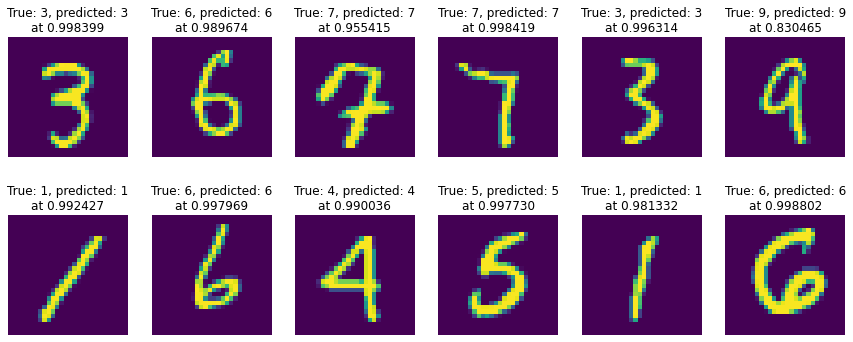

In [7]:
### Draw some random images from the test dataset and compare the true labels to the network outputs
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
### Loop over subplots
for axes_row in axes:
    for ax in axes_row:
        ### Draw the images
        test_index = rng.integers(0, len(TestDS))
        sample, label = TestDS[test_index]
        image, orig_label = TestDS_orig[test_index]
        ### Compute the predictions
        with torch.no_grad():
            output = Network(torch.unsqueeze(sample, dim=0).to(device=device))
            certainty, output = torch.max(output[0], 0)
            certainty = certainty.clone().cpu().item()
            output = output.clone().cpu().item()
        ### Show image
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i, predicted: %i\nat %f' % (orig_label, output, certainty))

(112, 96)
(122, 106)
5 5
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
0
tensor([1., 0., 0.])
tensor([0, 1, 2])


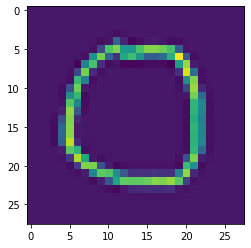

In [8]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
import cv2

width = 200  # canvas width
height = 200 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    filename = "user_input.jpg"
    global output_image 
    output_image.save(filename)
    ###### Centering begin
    # Load image as grayscale and obtain bounding box coordinates
    image = cv2.imread('user_input.jpg', 0)
    height, width = image.shape
    x,y,w,h = cv2.boundingRect(image)

    # Create new blank image and shift ROI to new coordinates
    ROI = image[y:y+h, x:x+w]
    mask = np.zeros([ROI.shape[0]+10,ROI.shape[1]+10])
    width, height = mask.shape
    print(ROI.shape)
    print(mask.shape)
    x = width//2 - ROI.shape[0]//2 
    y = height//2 - ROI.shape[1]//2 
    print(x,y)
    mask[y:y+h, x:x+w] = ROI
#     print(mask)
    # Check if centering/masking was successful
#     plt.imshow(mask, cmap='viridis') 
    output_image = PIL.Image.fromarray(mask)
    compressed_output_image = output_image.resize((22,22))
#     # Enhance Saturation
#     converter = PIL.ImageEnhance.Color(compressed_output_image)
#     compressed_output_image = converter.enhance(2.5)
    # Enhance contrast
#     converter = PIL.ImageEnhance.Contrast(compressed_output_image)
#     compressed_output_image = converter.enhance(3.5)
    
    convert_tensor = torchvision.transforms.ToTensor()
    tensor_image = convert_tensor(compressed_output_image)
    tensor_image = torch.nn.functional.pad(tensor_image, (3,3,3,3), "constant", 0)
    # Normalization shoudl be done after padding i guess
    convert_tensor = torchvision.transforms.Normalize((0.1307), (0.3081))
    tensor_image = convert_tensor(tensor_image)
    plt.imshow(tensor_image.detach().cpu().numpy().reshape(28,28), cmap='viridis')
    # Debugging
#     print(tensor_image)
#     print(np.array(compressed_output_image.getdata())) # Get data values)
#     print(np.array(image.getdata()))

    ### Compute the predictions
    with torch.no_grad():
        output0 = Network(torch.unsqueeze(tensor_image, dim=0).to(device=device))
        print(output0)
        certainty, output = torch.max(output0[0], 0)
        certainty = certainty.clone().cpu().item()
        output = output.clone().cpu().item()
        certainty1, output1 = torch.topk(output0[0],3)
        certainty1 = certainty1.clone().cpu()#.item()
        output1 = output1.clone().cpu()#.item()
#     print(certainty)
    print(output)
        
    print(certainty1)
    print(output1)

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
#     canvas.create_oval(x1, y1, x2, y2, fill="white",width=24)
    canvas.create_rectangle(x1, y1, x2, y2, fill="white",width=12)
    draw.line([x1, y1, x2, y2],fill="white",width=6)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("L", (width, height), 0)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="save",command=save)
button.pack()

master.mainloop()

In [14]:
# Debugging
# plt.imshow(image, cmap='viridis')

## References:
https://stackoverflow.com/questions/59535286/improve-real-life-results-of-neural-network-trained-with-mnist-dataset

# Repeat the procedure for CNNs

In [78]:
### Define the label transform from an integer to a set of probabilities
def target_transform(inlabel):
    newlabel = torch.zeros(10)
    newlabel[inlabel] = 1.
    return newlabel

### Reinitialize datasets with the transforms
TrainDS = torchvision.datasets.MNIST(fname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))
TestDS = torchvision.datasets.MNIST(fname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))

### Initialize DataLoaders as PyTorch convenience
TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=200)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=1000)

### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

Network = torch.nn.Sequential(      #  1x28x28
    torch.nn.Conv2d(1, 12, (9, 9)),  #  12x20x20
    torch.nn.MaxPool2d((2, 2)),     #  12x10x10
    torch.nn.ReLU(),
    torch.nn.Conv2d(12, 24, (5, 5)), # 24x 6x 6
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((3, 3)),     # 24x 2x 2
    torch.nn.Flatten(),             #       96
    torch.nn.Linear(96, 256),        #       16
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),        #       10
    torch.nn.Softmax(dim=1)
)
Network.to(device=device)

### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
crit = torch.nn.BCELoss()
# crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=0.4)

Sequential(
  (0): Conv2d(1, 12, kernel_size=(9, 9), stride=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=96, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
  (10): Softmax(dim=1)
)
35610 trainable parameters


In [79]:
### Baseline: just say it's anything at probability 1/N, what's the loss?
N = 10
labels = torch.zeros(1, 10, dtype=torch.float32)
labels[0, 3] = 1.
output = torch.full_like(labels, 1./N)
print(crit(output, labels))

tensor(0.3251)


In [80]:
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, 18)

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for inputs, labels in tqdm(TrainDL, leave=False):
        opt.zero_grad() # zero gradient values
        inputs = inputs.to(device=device) # move input and label tensors to the device with the model
        labels = labels.to(device=device)
        outputs = Network(inputs) # compute model outputs
        loss = crit(outputs, labels) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputs) # add the batch loss to the running loss
        samples += len(inputs) # update the number of processed samples
    tr_loss /= samples # compute training loss
    print(e, tr_loss)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

1 0.09264836195545892


  0%|          | 0/300 [00:00<?, ?it/s]

2 0.019920889198159177


  0%|          | 0/300 [00:00<?, ?it/s]

3 0.013826431520283223


  0%|          | 0/300 [00:00<?, ?it/s]

4 0.011060708032455296


  0%|          | 0/300 [00:00<?, ?it/s]

5 0.009606973744230345


  0%|          | 0/300 [00:00<?, ?it/s]

6 0.008401718128394957


  0%|          | 0/300 [00:00<?, ?it/s]

7 0.007377864027318234


  0%|          | 0/300 [00:00<?, ?it/s]

8 0.006509283360598298


  0%|          | 0/300 [00:00<?, ?it/s]

9 0.006097381164630254


  0%|          | 0/300 [00:00<?, ?it/s]

10 0.005498723037502108


  0%|          | 0/300 [00:00<?, ?it/s]

11 0.005158796334289946


  0%|          | 0/300 [00:00<?, ?it/s]

12 0.004679046658954272


  0%|          | 0/300 [00:00<?, ?it/s]

13 0.004327196005518393


  0%|          | 0/300 [00:00<?, ?it/s]

14 0.003996921355525653


  0%|          | 0/300 [00:00<?, ?it/s]

15 0.003626312121535496


  0%|          | 0/300 [00:00<?, ?it/s]

16 0.0033747833439459404


  0%|          | 0/300 [00:00<?, ?it/s]

17 0.003126707449312865


In [81]:
### Set model in evaluation mode
Network.eval()

### Compute the test loss
with torch.no_grad():
    te_loss = 0.
    samples = 0
    accuracy = 0
    ### Loop over batches
    for inputs, labels in tqdm(TestDL):
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = Network(inputs)
        loss = crit(outputs, labels)
        te_loss += loss.clone().cpu().item()*len(inputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs)
    te_loss /= samples
    accuracy /= samples
    print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.005985, accuracy: 0.990500


In [14]:
torch.save(Network, 'model_torch_MNIST_CNN_99_1.chk')

In [22]:
Network = torch.load('model_torch_MNIST_CNN_0.chk')
device='cpu'

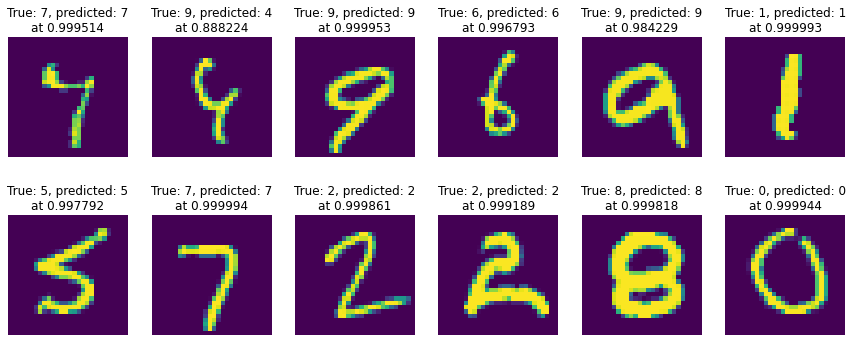

In [15]:
### Draw some random images from the test dataset and compare the true labels to the network outputs
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
### Loop over subplots
for axes_row in axes:
    for ax in axes_row:
        ### Draw the images
        test_index = rng.integers(0, len(TestDS))
        sample, label = TestDS[test_index]
        image, orig_label = TestDS_orig[test_index]
        ### Compute the predictions
        with torch.no_grad():
            output = Network(torch.unsqueeze(sample, dim=0).to(device=device))
            certainty, output = torch.max(output[0], 0)
            certainty = certainty.clone().cpu().item()
            output = output.clone().cpu().item()
        ### Show image
        ax.set_axis_off()
        ax.imshow(image)
#         print(sample)
        ax.set_title('True: %i, predicted: %i\nat %f' % (orig_label, output, certainty))

tensor([[0.0000e+00, 2.2576e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]])
7
tensor([1.0000e+00, 2.2576e-06, 0.0000e+00])
tensor([7, 1, 0])


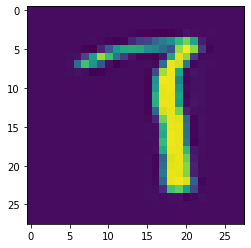

In [82]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
import cv2

width = 200  # canvas width
height = 200 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    filename = "user_input.jpg"
    global output_image 
    output_image.save(filename)
    ###### Centering begin
    # Load image as grayscale and obtain bounding box coordinates
    image = cv2.imread('user_input.jpg', 0)
#     print(image)
    height, width = image.shape
    x,y,w,h = cv2.boundingRect(image)

    # Create new blank image and shift ROI to new coordinates
    ROI = image[y:y+h, x:x+w]
    mask = np.zeros([ROI.shape[0]+10,ROI.shape[1]+10])
    width, height = mask.shape
#     print(ROI.shape)
#     print(mask.shape)
    x = width//2 - ROI.shape[0]//2 
    y = height//2 - ROI.shape[1]//2 
#     print(x,y)
    mask[y:y+h, x:x+w] = ROI
#     print(mask)
    # Check if centering/masking was successful
#     plt.imshow(mask, cmap='viridis') 
    output_image = PIL.Image.fromarray(mask)
    compressed_output_image = output_image.resize((22,22))
#     # Enhance Saturation
#     converter = PIL.ImageEnhance.Color(compressed_output_image)
#     compressed_output_image = converter.enhance(2.5)
    # Enhance contrast
#     converter = PIL.ImageEnhance.Contrast(compressed_output_image)
#     compressed_output_image = converter.enhance(3.5)
    
    convert_tensor = torchvision.transforms.ToTensor()
    tensor_image = convert_tensor(compressed_output_image)
    tensor_image = torch.nn.functional.pad(tensor_image, (3,3,3,3), "constant", 0)
    # Normalization shoudl be done after padding i guess
    convert_tensor = torchvision.transforms.Normalize((0.1307), (0.3081))
    tensor_image = convert_tensor(tensor_image)
    plt.imshow(tensor_image.detach().cpu().numpy().reshape(28,28), cmap='viridis')
    # Debugging
#     print(tensor_image)
#     print(np.array(compressed_output_image.getdata())) # Get data values)
#     print(np.array(image.getdata()))

    ### Compute the predictions
    with torch.no_grad():
        output0 = Network(torch.unsqueeze(tensor_image, dim=0).to(device=device))
        print(output0)
        certainty, output = torch.max(output0[0], 0)
        certainty = certainty.clone().cpu().item()
        output = output.clone().cpu().item()
        certainty1, output1 = torch.topk(output0[0],3)
        certainty1 = certainty1.clone().cpu()#.item()
        output1 = output1.clone().cpu()#.item()
#     print(certainty)
    print(output)
        
    print(certainty1)
    print(output1)

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
#     canvas.create_oval(x1, y1, x2, y2, fill="white",width=24)
    canvas.create_rectangle(x1, y1, x2, y2, fill="white",width=12)
    draw.line([x1, y1, x2, y2],fill="white",width=8)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("L", (width, height), 0)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="save",command=save)
button.pack()

master.mainloop()